## 安裝Fuzzy package

In [1]:
# !pip install scikit-fuzzy

## 建立 Fuzzy Set 及設定數值範圍 

## import packages

In [2]:
# import the package
## fuzzy control
import skfuzzy as fuzz
import skfuzzy.control as fuzz_ctrl

import numpy as np
## plot the schematic
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## Membership functions

### Universe of discourse
指一個變量的可能值的整個範圍，這些值可以被表示為模糊集合。語境空間可以被視為變量的輸入和輸出範圍，可以根據系統需求進行定義和設置。

例如，假設我們正在設計一個模糊控制器來控制空調系統的溫度。在這種情況下，我們可以定義一個溫度語境空間，表示可能的溫度值的整個範圍，例如15度到35度之間。然後，我們可以在這個範圍內定義一個或多個模糊集合，來描述溫度的變化趨勢，例如“低溫”，“中溫”和“高溫”。

In [3]:
# Range

## range of temp. & soil & watering 
### 建立membership function 的全域範圍，下面numpy只是一個範圍還沒真正定義出模糊的區間
x_temp_range = np.arange(32,123,1,np.float32)
x_soil_range = np.arange(0,101,1,np.float32)
y_time_range = np.arange(0,31,1,np.float32)
##　variable and membership functions
### 建立三個模糊區間：temp(input), soil(input), time(output)
'''
class Antecedent(
    universe: Any,
    label: str
)
'''
x_temp = fuzz_ctrl.Antecedent(x_temp_range, "temp")
x_soil = fuzz_ctrl.Antecedent(x_soil_range, "soil")

'''
class Consequent(
    universe: NDArray[float32],
    label: str,
    defuzzify_method: str = 'centroid'
)
'''
y_time = fuzz_ctrl.Consequent(y_time_range, "time")
## 質心模糊
y_time.defuzzify_method = "centroid" # 預設就是COG



### Scope/Domain

In [4]:
# fuzz.trimf通常用於定義具有三角形形狀的模糊集合
# fuzzy.trapmf通常用於定義具有梯形形狀的模糊集合

## temp 定義5個fuzzy set (input1)
x_temp["cold"] = fuzz.trapmf(x_temp_range,[32,32,50,68])
x_temp["cool"] = fuzz.trimf(x_temp_range,[50,68,86])
x_temp["normal"] = fuzz.trimf(x_temp_range,[59,77,95])
x_temp["warm"] = fuzz.trimf(x_temp_range,[68,86,104])
x_temp["hot"] = fuzz.trapmf(x_temp_range,[86,104,122,122])

## soil 定義3個fuzzy set (input2)
x_soil["dry"] = fuzz.trapmf(x_soil_range,[0,0,16.5,49.5])
x_soil["moist"] = fuzz.trapmf(x_soil_range,[16.5,40.5,62.5,88.6])
x_soil["wet"] = fuzz.trapmf(x_soil_range,[65.5,88.6,100,100])

## time 定義3個fuzzy set (output)
y_time["short"] = fuzz.trapmf(y_time_range,[0,0,2,8])
y_time["medium"] = fuzz.trapmf(y_time_range,[2,10,15,23])
y_time["long"] = fuzz.trapmf(y_time_range,[16,23,30,30])



### Rules
|        | Hot      | Warm     | Normal   | Cool     | Cold     |
|--------|----------|----------|----------|----------|----------|
| Dry    | long     | long     | medium   | medium   | short    |
| Moist  | medium   | medium   | medium   | short    | short    |
| Wet    | short    | short    | short    | short    | short    |


In [5]:
## 輸出規則 (根據上表)
rule_long = fuzz_ctrl.Rule(antecedent=((x_temp["hot"]&x_soil["dry"])|(x_temp["warm"]&x_soil["dry"])),consequent=y_time["long"],label="long")
rule_med = fuzz_ctrl.Rule(antecedent=((x_temp["normal"]&x_soil["dry"])|(x_temp["cool"]&x_soil["dry"])|(x_temp["hot"]&x_soil["moist"])|(x_temp["warm"]&x_soil["moist"])|(x_temp["normal"]&x_soil["moist"])),consequent = y_time["medium"],label="medium")
rule_short = fuzz_ctrl.Rule(antecedent=((x_temp["cool"]&x_soil["moist"])|(x_temp["cold"]&x_soil["moist"])|(x_temp["hot"]&x_soil["wet"])|(x_temp["warm"]&x_soil["wet"])|(x_temp["normal"]&x_soil["wet"])|(x_temp["cool"]&x_soil["wet"])|(x_temp["cold"]&x_soil["wet"])|(x_temp['cold']&x_soil['dry'])),consequent=y_time["short"],label="short")


In [6]:
# 根據前面的規則建立此系統，可以視為建立起整個函數
system = fuzz_ctrl.ControlSystem(rules=[rule_long,rule_med,rule_short])
# 根據建立起來的membership function（system）去模擬
sys_sim = fuzz_ctrl.ControlSystemSimulation(system)


## 使用者輸入

In [7]:
# 自訂輸入條件 Crisp input
# input_temp = int(input("請輸入溫度(℉))"))
# input_soil = int(input("請輸入土壤濕度"))
input_temp = 62
input_soil = 25

# 將數值送入模擬器（根據一開始建立大label)
sys_sim.input["temp"] = input_temp
sys_sim.input["soil"] = input_soil

# system compute
sys_sim.compute()
out_y = sys_sim.output["time"]
print("When {}℉(Air temperature) and {}%(Soil moisture), Duration Time is {:.2f} min.".format(input_temp, input_soil, out_y))


When 62℉(Air temperature) and 25%(Soil moisture), Duration Time is 11.38 min.


## Membership Grage

In [8]:
# Setup the dic. to save the label and the grade.
temp_membership_grade = {}
soil_membership_grade = {}
# time_membership_grade = {}
print("Membership Grade:")
print("-"*100)
for key in x_temp.terms: # x_temp.terms 是存放label的一個OrderedDict
    grade = fuzz.interp_membership(x_temp_range, x_temp[key].mf, input_temp) # To get the grade
    temp_membership_grade[key] = grade
    print(f"{key}:{grade:.2f}", end='\t')
print('')
print("-"*100)
for key in x_soil.terms:
    grade = fuzz.interp_membership(x_soil_range, x_soil[key].mf, input_soil)
    soil_membership_grade[key] = grade
    print(f"{key}:{grade:.2f}", end='\t')
print('')
# print("-"*100)
# for key in y_time.terms:
#     grade = fuzz.interp_membership(y_time_range, y_time[key].mf, out_y)
#     time_membership_grade[key] = grade
#     print(f"{key}:{grade:.2f}", end='\t')
# print('')

Membership Grade:
----------------------------------------------------------------------------------------------------
cold:0.33	cool:0.67	normal:0.17	warm:0.00	hot:0.00	
----------------------------------------------------------------------------------------------------
dry:0.74	moist:0.35	wet:0.00	


## 計算time的Membership grade

In [9]:
time_dict = {
    "hot,dry": "long",
    "warm,dry": "long",
    "normal,dry": "medium",
    "cool,dry": "medium",
    "hot,moist": "medium",
    "warm,moist": "medium",
    "normal,moist": "medium",
    "cool,moist": "short",
    "cold,moist": "short",
    "hot,wet": "short",
    "warm,wet": "short",
    "normal,wet": "short",
    "cool,wet": "short",
    "cold,wet": "short",
    "cold,dry": "short"
}

In [10]:
# 留下不是0的數值
temp_nonzero = {k: v for k, v in temp_membership_grade.items() if v != 0}
soil_nonzero = {k: v for k, v in soil_membership_grade.items() if v != 0}
# print(temp_nonzero)
# print(soil_nonzero)
# temp_nonzero = temp_membership_grade
# soil_nonzero = soil_membership_grade

# 排列組合後進行and-->取小
and_set = []
for i in temp_nonzero:
    for j in soil_nonzero:
        time_label = time_dict[i+','+j]
        and_set.append((time_label, min(temp_nonzero[i], soil_nonzero[j])))

# 最後同樣的label進行o-->max
or_set = {}
for key, value in and_set:
    if key in or_set:
        # 更新已有key的值
        or_set[key] = max(or_set[key], value)
    else:
        # 添加新key
        or_set[key] = value
print("Membership Grade of Time:")
for i in or_set:
    print(f'{i}: {or_set[i]:.2f}', end='\t')
# print(or_set)
time_membership_grade = or_set


Membership Grade of Time:
short: 0.35	medium: 0.67	long: 0.00	

## 可視化

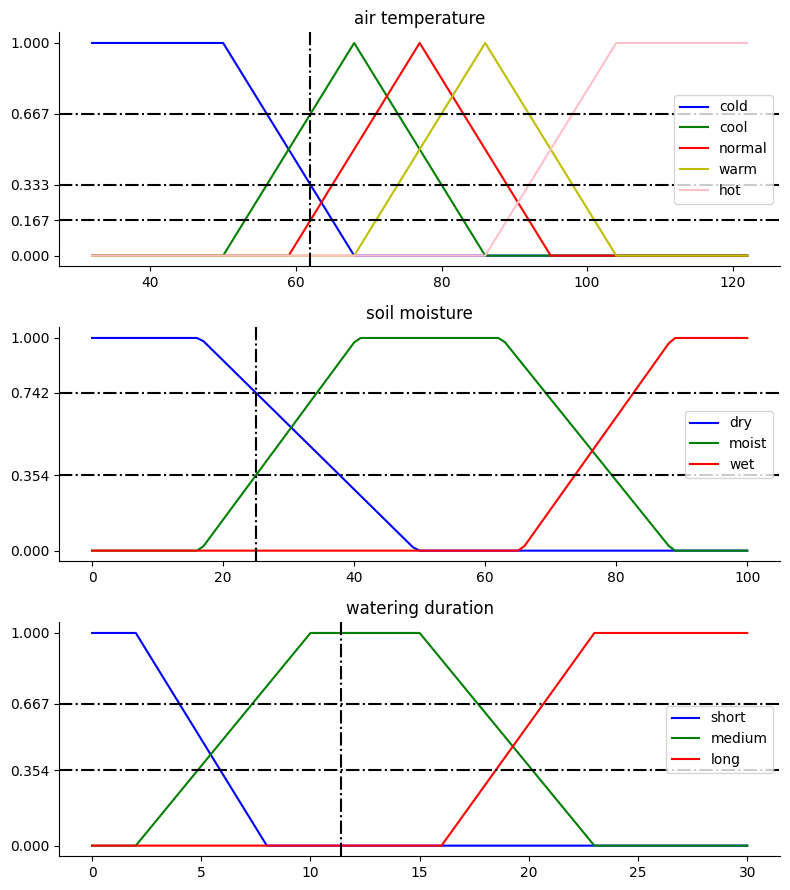

In [11]:
# Visualize these universes and membership functions
fig,(figure1,figure2,figure3)=plt.subplots(nrows=3,figsize=(8,9))

# figure1 is x_temp 
## Plot membership function
# x_temp_cold_value = fuzz.interp_membership(x_temp_range, x_temp['cold'].mf, x_temp_range) # 取出某一個fuzzy set 的數值
# figure1.plot(x_temp_range,x_temp_cold_value,'b',linewidth=1.5,label='cold')
figure1.plot(x_temp_range,fuzz.trapmf(x_temp_range,[32,32,50,68]),'b',linewidth=1.5,label='cold') ## 可以改為上面的兩行code
figure1.plot(x_temp_range,fuzz.trimf(x_temp_range,[50,68,86]),'g',linewidth=1.5,label='cool')
figure1.plot(x_temp_range,fuzz.trimf(x_temp_range,[59,77,95]),'r',linewidth=1.5,label='normal')
figure1.plot(x_temp_range,fuzz.trimf(x_temp_range,[68,86,104]),'y',linewidth=1.5,label='warm')
figure1.plot(x_temp_range,fuzz.trapmf(x_temp_range,[86,104,122,122]),'pink',linewidth=1.5,label='hot')

## Plot the input and the grade
figure1.axvline(x=input_temp, color='k', linestyle='-.')
yticks_temp=[0, 1]
for key in temp_membership_grade:
  if temp_membership_grade[key] != 0:
    figure1.axhline(y=temp_membership_grade[key], color='k', linestyle='-.')
    yticks_temp.append(temp_membership_grade[key])
figure1.set_yticks(yticks_temp)

figure1.set_title('air temperature')
figure1.legend()

# figure2 is x_soil
## Plot membership function
figure2.plot(x_soil_range,fuzz.trapmf(x_soil_range,[0,0,16.5,49.5]),'b',linewidth=1.5,label='dry')
figure2.plot(x_soil_range,fuzz.trapmf(x_soil_range,[16.5,40.5,62.5,88.6]),'g',linewidth=1.5,label='moist')
figure2.plot(x_soil_range,fuzz.trapmf(x_soil_range,[65.5,88.6,100,100]),'r',linewidth=1.5,label='wet')

## Plot the input and the grade
figure2.axvline(x=input_soil, color='k', linestyle='-.')
yticks_soil=[0, 1]
for key in soil_membership_grade:
  if soil_membership_grade[key] != 0:
    figure2.axhline(y=soil_membership_grade[key], color='k', linestyle='-.')
    yticks_soil.append(soil_membership_grade[key])
figure2.set_yticks(yticks_soil)
figure2.set_title('soil moisture')
figure2.legend()

# figure 3 is y_time
## Plot membership function
figure3.plot(y_time_range,fuzz.trapmf(y_time_range,[0,0,2,8]),'b',linewidth=1.5,label='short')
figure3.plot(y_time_range,fuzz.trapmf(y_time_range,[2,10,15,23]),'g',linewidth=1.5,label='medium')
figure3.plot(y_time_range,fuzz.trapmf(y_time_range,[16,23,30,30]),'r',linewidth=1.5,label='long')

## Plot the input and the grade
figure3.axvline(x=out_y, color='k', linestyle='-.')
yticks_time=[0, 1]
for key in time_membership_grade:
  if time_membership_grade[key] != 0:
    figure3.axhline(y=time_membership_grade[key], color='k', linestyle='-.')
    yticks_time.append(time_membership_grade[key])
figure3.set_yticks(yticks_time)
figure3.set_title('watering duration')
figure3.legend()

# plot 2d figures
for fi in (figure1,figure2,figure3):
  fi.spines['top'].set_visible(False)
  fi.spines['right'].set_visible(False)
  fi.get_xaxis().tick_bottom()
  fi.get_yaxis().tick_left()

plt.tight_layout()

# 3D figure


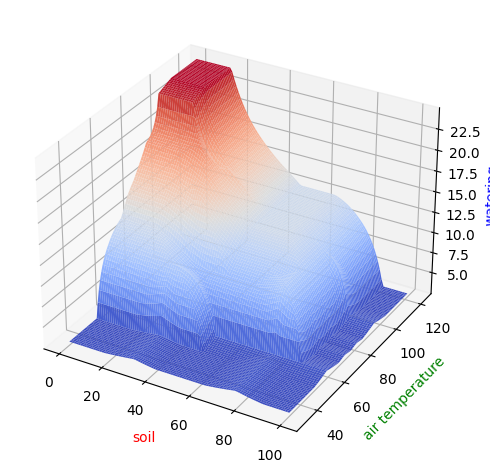

In [12]:
def funz(x, y):
  sys_sim.input["temp"] = y
  sys_sim.input["soil"] = x 
  sys_sim.compute()
  z=sys_sim.output["time"]
  return z

fig1 = plt.figure() # 建立一個繪圖物件
ax = Axes3D(fig1) # 用這個繪圖物件建立一個Axes物件(有3D座標) ### localhost 無法單用這一行顯示圖片
ax = fig1.add_subplot(111, projection='3d') ### 設為一個子圖來顯示


X, Y = np.meshgrid(x_soil_range,x_temp_range)
Z = funz(X, Y)
ax.plot_surface(X, Y, Z, rstride=1,cstride=1,cmap=plt.cm.coolwarm)#用取樣點(x,y,z)去構建曲面
ax.set_xlabel('soil', color='r')
ax.set_ylabel('air temperature', color='g')
ax.set_zlabel('watering', color='b')#給三個座標軸註明
plt.tight_layout() # 顯示所有axis-label避免被裁切
plt.show()#顯示模組中的所有繪圖物件
